In [1]:
import numpy as np
import tables as tb
import matplotlib.pyplot as plt

from astropy.cosmology import Planck15 as cosmo
from scipy.interpolate import interp1d

In [2]:
def scatter_contour(x, y,
                    levels=10,
                    threshold=100,
                    log_counts=False,
                    histogram2d_args=None,
                    plot_args=None,
                    contour_args=None,
                    filled_contour=True,
                    ax=None):
    """Scatter plot with contour over dense regions
    
    from Statistics, Data Mining, and Machine Learning in Astronomy
    by Željko Ivezić, Andrew J. Connolly, Jacob T. VanderPlas, Alexander Gray
    
    Parameters
    ----------
    x, y : arrays
        x and y data for the contour plot
    levels : integer or array (optional, default=10)
        number of contour levels, or array of contour levels
    threshold : float (default=100)
        number of points per 2D bin at which to begin drawing contours
    log_counts :boolean (optional)
        if True, contour levels are the base-10 logarithm of bin counts.
    histogram2d_args : dict
        keyword arguments passed to numpy.histogram2d
        see doc string of numpy.histogram2d for more information
    plot_args : dict
        keyword arguments passed to plt.plot.  By default it will use
        dict(marker='.', linestyle='none').
        see doc string of pylab.plot for more information
    contour_args : dict
        keyword arguments passed to plt.contourf or plt.contour
        see doc string of pylab.contourf for more information
    filled_contour : bool
        If True (default) use filled contours. Otherwise, use contour outlines.
    ax : pylab.Axes instance
        the axes on which to plot.  If not specified, the current
        axes will be used
    Returns
    -------
    points, contours :
       points is the return value of ax.plot()
       contours is the return value of ax.contour or ax.contourf
    """
    x = np.asarray(x)
    y = np.asarray(y)

    default_contour_args = dict(zorder=2)
    default_plot_args = dict(marker='.', linestyle='none', zorder=1)

    if plot_args is not None:
        default_plot_args.update(plot_args)
    plot_args = default_plot_args

    if contour_args is not None:
        default_contour_args.update(contour_args)
    contour_args = default_contour_args

    if histogram2d_args is None:
        histogram2d_args = {}

    if contour_args is None:
        contour_args = {}

    if ax is None:
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        ax = plt.gca()

    H, xbins, ybins = np.histogram2d(x, y, **histogram2d_args)

    if log_counts:
        H = np.log10(1 + H)
        threshold = np.log10(1 + threshold)

    levels = np.asarray(levels)

    if levels.size == 1:
        levels = np.linspace(threshold, H.max(), levels)

    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

    i_min = np.argmin(levels)

    # draw a zero-width line: this gives us the outer polygon to
    # reduce the number of points we draw
    # somewhat hackish... we could probably get the same info from
    # the full contour plot below.
    outline = ax.contour(H.T, levels[i_min:i_min + 1],
                         linewidths=0, extent=extent,
                         alpha=0)

    if filled_contour:
        contours = ax.contourf(H.T, levels, extent=extent, **contour_args)
    else:
        contours = ax.contour(H.T, levels, extent=extent, **contour_args)

    X = np.hstack([x[:, None], y[:, None]])

    if len(outline.allsegs[0]) > 0:
        outer_poly = outline.allsegs[0][0]
        try:
            # this works in newer matplotlib versions
            from matplotlib.path import Path
            points_inside = Path(outer_poly).contains_points(X)
        except ImportError:
            # this works in older matplotlib versions
            import matplotlib.nxutils as nx
            points_inside = nx.points_inside_poly(X, outer_poly)

        Xplot = X[~points_inside]
    else:
        Xplot = X

    points = ax.plot(Xplot[:, 0], Xplot[:, 1], **plot_args)

    return points, contours

## Cosmology

Calculate and tabulated the angular diameter distance, luminnosity distance, Hubble, etc.

In [3]:
zmin = 0.05; zmax = 0.15;
littleh = cosmo.h
print("h=",littleh)
Vaspec = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin))
print("Volume of Aspec={0:.4f} Gpc^3".format(Vaspec.value/1e9))

h= 0.6774
Volume of Aspec=1.0553 Gpc^3


In [4]:
DLmax = cosmo.luminosity_distance(zmax).value
print("DL max={:.4f} Mpc".format(DLmax))

DL max=736.2263 Mpc


In [5]:
zarr  = np.linspace(zmin,zmax,num=200)
DLarr = cosmo.luminosity_distance(zarr).value
chiarr = cosmo.comoving_distance(zarr).value
fDLz  = interp1d(zarr,DLarr,kind=1)
fchiz  = interp1d(zarr,chiarr,kind=1)

Plot the distance

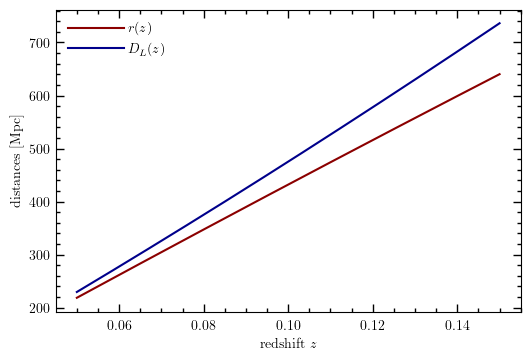

In [6]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(111)
ax.set_xlabel("redshift $z$")
ax.set_ylabel("distances [${\\rm Mpc}$]")
ax.plot(zarr,chiarr,c="DarkRed",label="$r(z)$")
ax.plot(zarr,DLarr,c="DarkBlue",label="$D_L(z)$")
ax.legend(loc="upper left",handlelength=4)
plt.savefig("distance_z.png")

Plot the distance modulus ($K_s - M_K$)

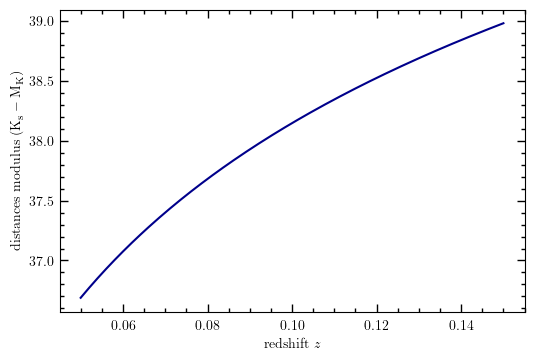

In [7]:
Dmodzarr = 5*np.log10(DLarr*1e5)-6*np.log10(1+zarr)+0.35*0.03
fzDmod = interp1d(Dmodzarr,zarr,kind=1)

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(111)
ax.set_xlabel("redshift $z$")
ax.set_ylabel("distances modulus (${\\rm K_s}-{\\rm M_K}$)")
ax.plot(zarr,5*np.log10(DLarr*1e5)-6*np.log10(1+zarr)+0.35*0.03,c="DarkBlue")
plt.savefig("Modulus_z.png")

## Input luminosity function (the ground truth!)

Schechter function with magnitude interval

In [8]:
def SchechterM(M,phistar,Mstar,alpha):
    LovLstar = 10**(0.4*(Mstar-M))
    return np.log(10)/2.5*phistar*LovLstar**(1+alpha)*np.exp(-LovLstar)

K-band Luminosity function similar to Kochanek et al. (2001), but re-scale the normalization

In [9]:
Marr = np.linspace(-23,-27,num=400)
phistar = 0.0178 * littleh**3
Mstar = -23.39 + 5*np.log10(littleh)
alpha = -1.09
LFMarr = np.array([SchechterM(M,phistar,Mstar,alpha) for M in Marr])

## Read mock data (flux-limited)

In [58]:
mockfname = 'aspec_mock_hr4.hdf5'
h5file = tb.open_file(mockfname,"r")
agl   = h5file.root.RA.read()
agb  = h5file.root.Dec.read()
azred = h5file.root.zred.read()
aMKs  = h5file.root.MKs.read()
aKs   = h5file.root.Ks.read()
h5file.close()

In [59]:
# Galactic plane cut
galsel = np.abs(agb) > 10
fskyASPEC = (1-np.cos(80*np.pi/180))
agl   = agl[galsel]
agb   = agb[galsel]
azred = azred[galsel]
aMKs  = aMKs[galsel]
aKs   = aKs[galsel]

In [11]:
Ngals = len(azred)
print("Number of galaxies in the mock={:d}".format(Ngals))
FullskyArea = 4*np.pi/(np.pi/180)**2 * fskyASPEC
print("Number density = {:.3f} galaxies/sq. deg.".format(Ngals/FullskyArea))

Number of galaxies in the mock=724405
Number density = 21.250 galaxies/sq. deg.


## Look into the data

Let's take a look at the data

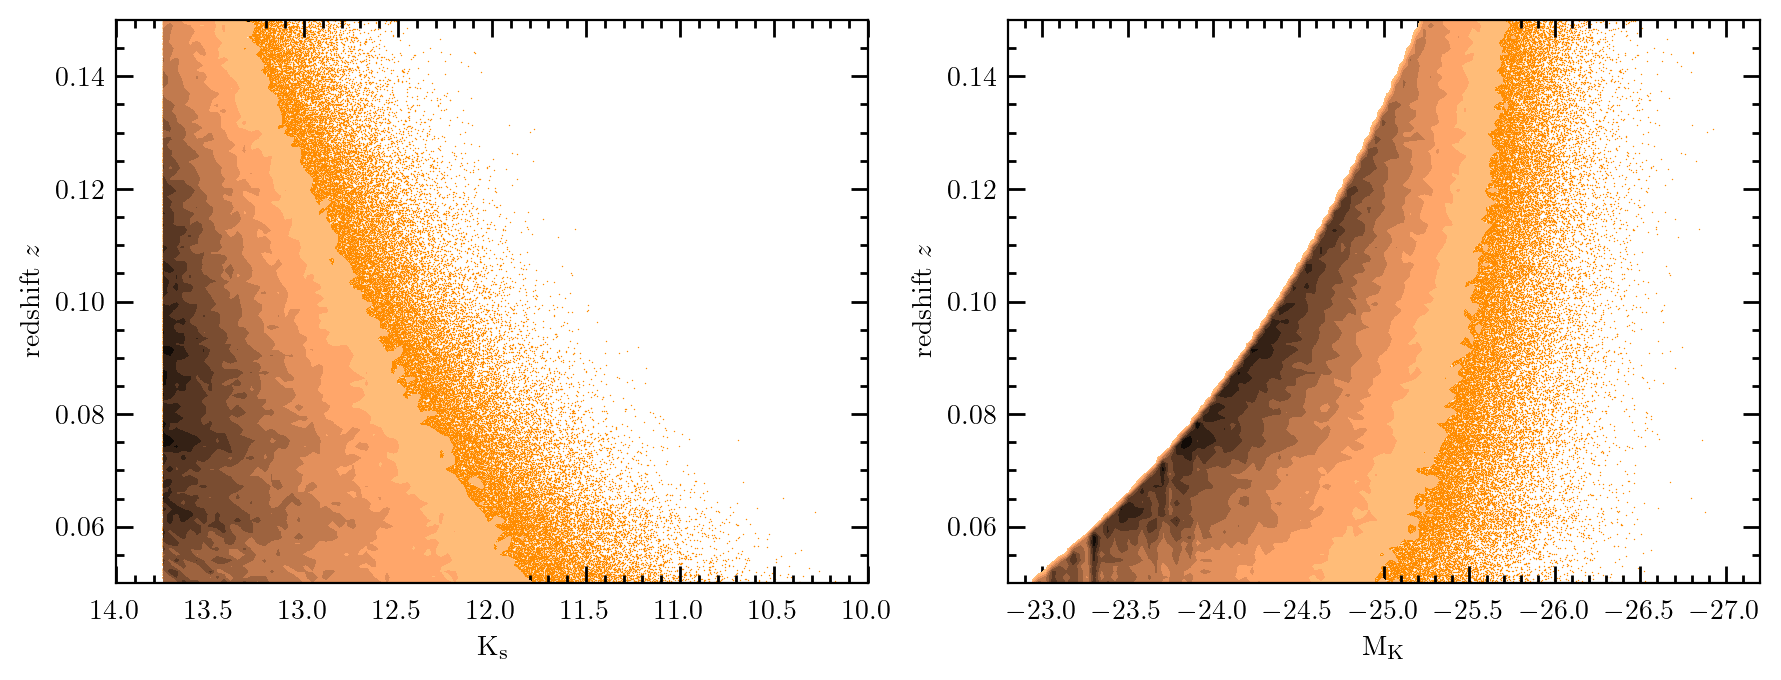

In [12]:
fig = plt.figure(figsize=(9,3.5),dpi=200)
ax1 = fig.add_subplot(121)
ax1.set_xlim(14,10)
ax1.set_xlabel("${\\rm K_s}$")
ax1.set_ylabel("redshift $z$")
#ax1.scatter(aKs,azred,marker="o",s=0.2,c="DarkRed",ec="none")
CS1 = scatter_contour(aKs,azred,threshold=60,log_counts=False,ax=ax1,histogram2d_args=dict(bins=100),
                plot_args=dict(marker='.',ms=1, linestyle='none', color='DarkOrange',mec="none"),
                contour_args=dict(cmap=plt.cm.copper_r))
ax2 = fig.add_subplot(122)
ax2.set_xlim(-22.8,-27.2)
ax2.set_xlabel("${\\rm M_K}$")
ax2.set_ylabel("redshift $z$")
#ax2.scatter(aMKs,azred,marker="o",s=0.2,c="DarkRed",ec="none")
CS2 = scatter_contour(aMKs,azred,threshold=60,log_counts=False,ax=ax2,histogram2d_args=dict(bins=100),
                plot_args=dict(marker='.',ms=1, linestyle='none', color='DarkOrange',mec="none"),
                contour_args=dict(cmap=plt.cm.copper_r))
plt.tight_layout()
plt.savefig("Flux_limited_sample.png")

0.05 0.07 224905
0.07 0.09 196827
0.09 0.10999999999999999 147554
0.10999999999999999 0.13 99486
0.13 0.15 55633


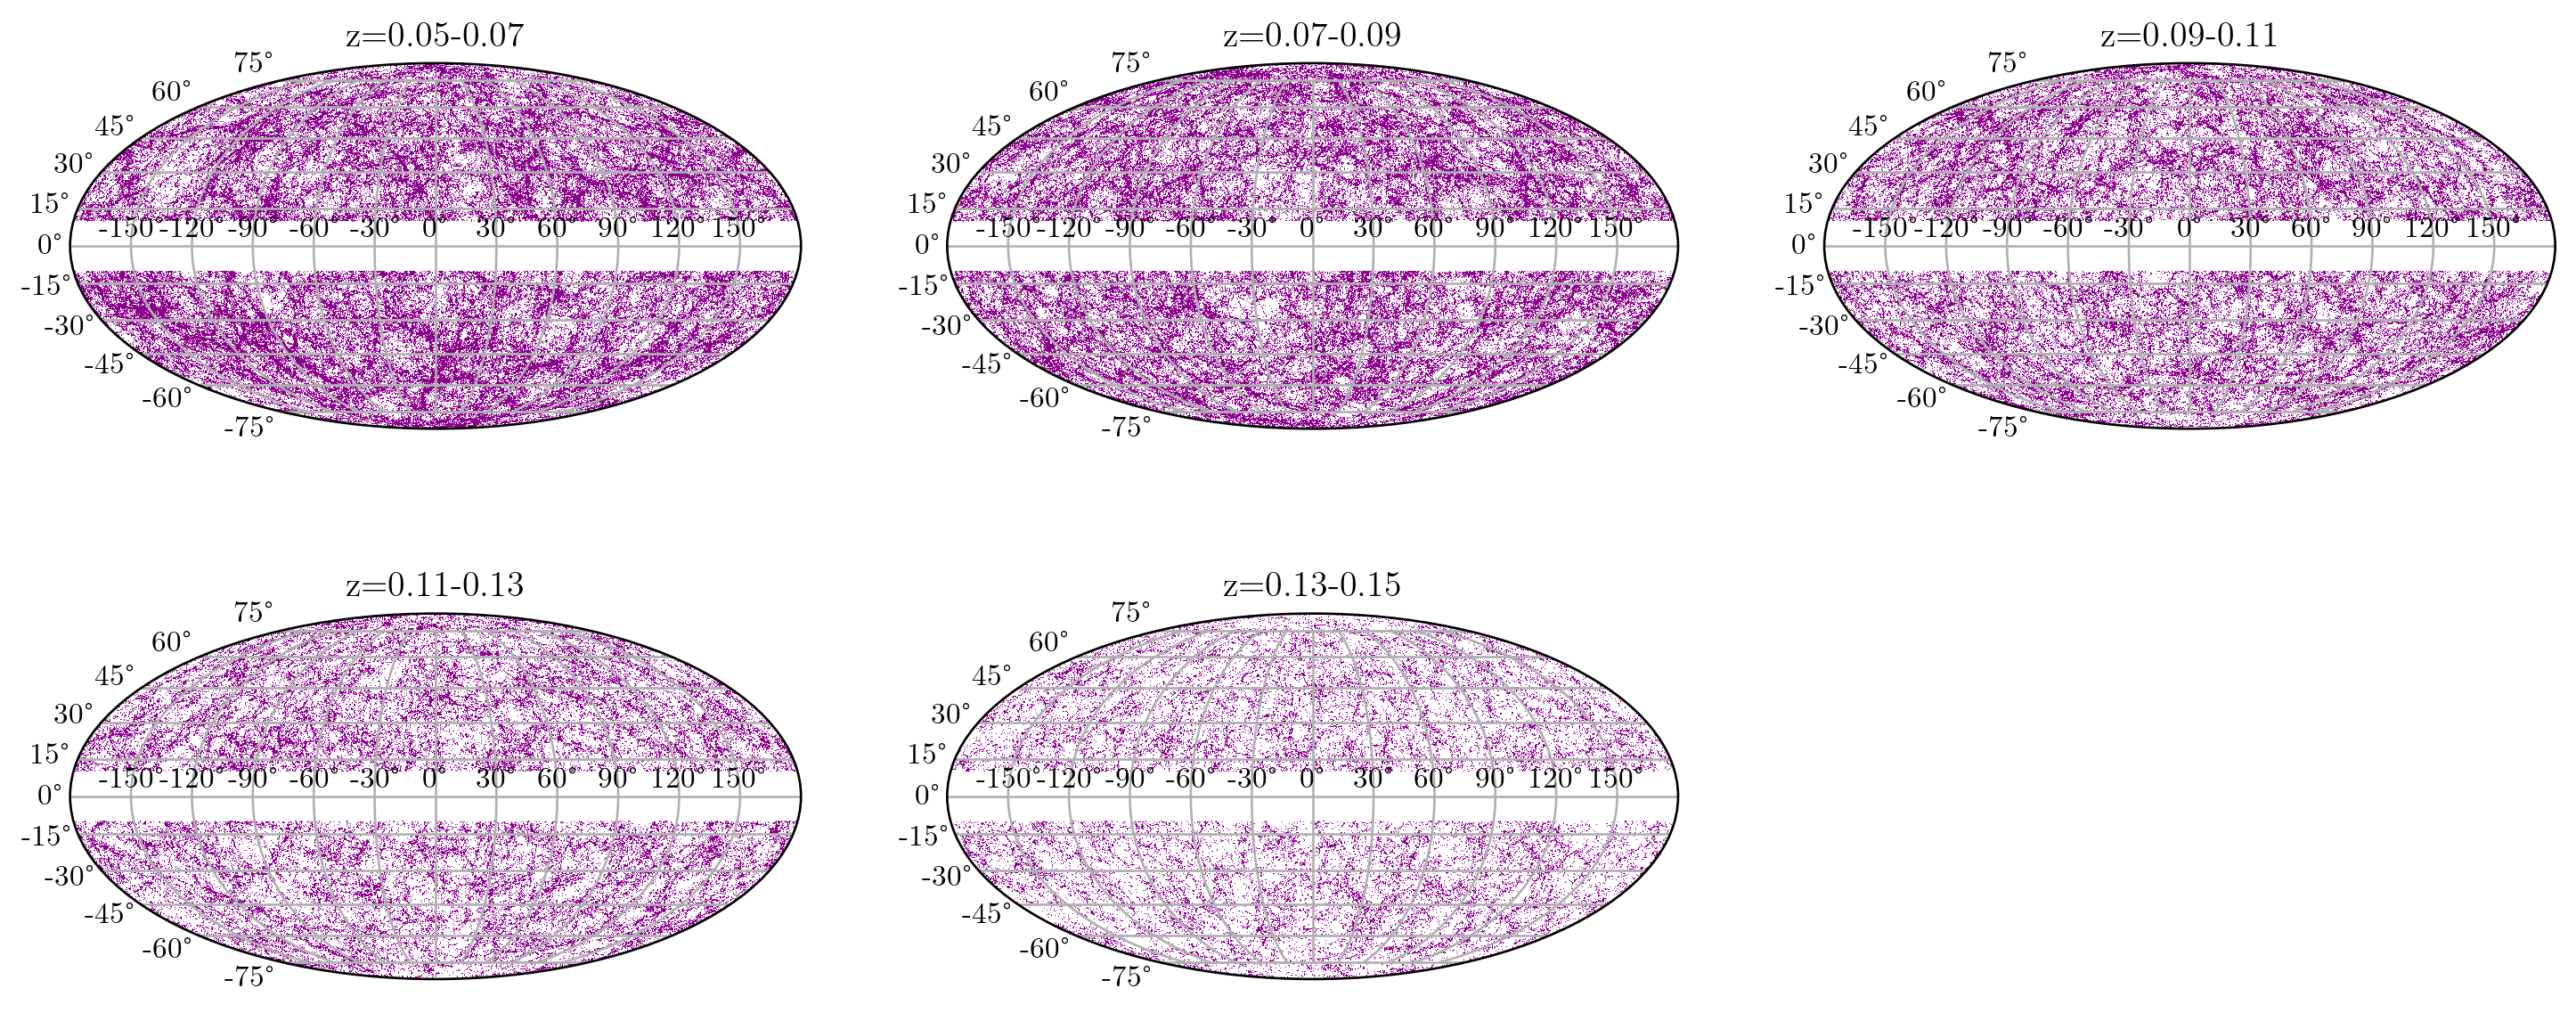

In [13]:
radian = np.pi/180
xshow = agl*radian
mm = agl > 180
xshow[mm] = xshow[mm] - 2*np.pi
yshow = agb*radian

azarr = np.linspace(0.05,0.15,num=6)
fig = plt.figure(figsize=(15,6.25),dpi=240)
for zindx in range(5):
    zmin_this = azarr[zindx]
    zmax_this = azarr[zindx+1]
    ax  = fig.add_subplot(2,3,zindx+1,projection="mollweide")
    ax.grid(True,alpha=1)
    mz = (azred>zmin_this)*(azred<=zmax_this)*(np.abs(yshow)>10*np.pi/180)
    print(zmin_this,zmax_this,np.sum(mz))
    ax.scatter(xshow[mz],yshow[mz],marker=",",s=0.1,c="DarkMagenta",ec=None)
    ax.set_title("z={:.2f}".format(zmin_this)+"-{:.2f}".format(zmax_this),fontsize=12)
plt.savefig("Aspec.png")

## Histogram

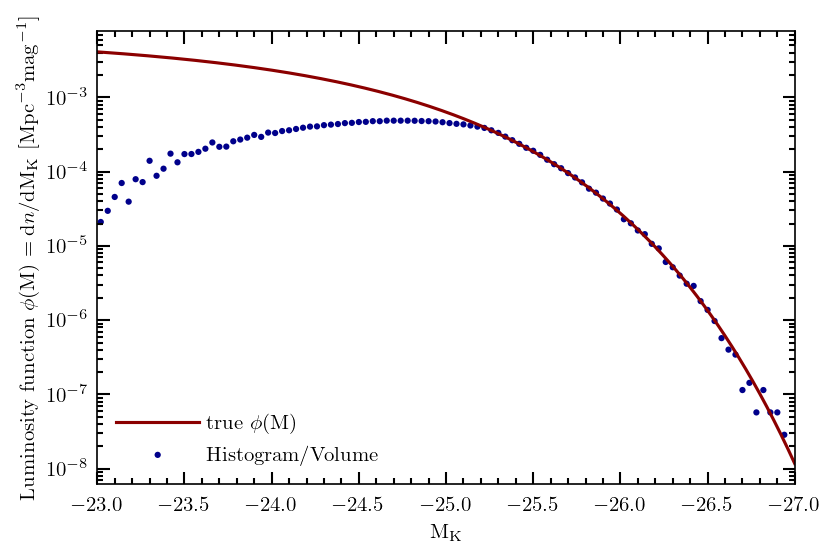

In [43]:
Mmax = -23
Mmin = -27

Volume = Vaspec.value*fskyASPEC

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([Mmax,Mmin])
ax.set_yscale("log")
ax.set_xlabel("${\\rm M_K}$")
ax.set_ylabel("Luminosity function $\phi({\\rm M})={\\rm d}n/{\\rm d M_K}$ [${\\rm Mpc}^{-3}{\\rm mag}^{-1}$]")
ax.plot(Marr,LFMarr,c="DarkRed",label="true $\phi({\\rm M})$")

Nbins = 100
DeltaM = (Mmax - Mmin)/Nbins
hist, bins = np.histogram(aMKs,bins=Nbins,range=(Mmin,Mmax),weights=np.ones(len(aMKs))/Volume/DeltaM)
binC = (bins[:-1]+bins[1:])/2
ax.scatter(binC,hist,marker=".",c="DarkBlue",ec="none",label="Histogram/Volume")

ax.legend(loc="lower left",handlelength=4)
plt.savefig("LF_hist.png")

## 1/Vmax-weighted Histogram

In [19]:
Vmaxzarr = [(cosmo.comoving_volume(zthis) - cosmo.comoving_volume(zmin)).value*fskyASPEC for zthis in zarr]
fVmaxz   = interp1d(zarr,Vmaxzarr,kind=1)

def findVmax(Mk):
    Dmodmax = 13.75-Mk
    if Dmodmax >= np.max(Dmodzarr):
        return Vaspec.value*fskyASPEC
    else:
        zmaxMk = fzDmod(Dmodmax)
        return fVmaxz(zmaxMk)
aVmaxMk = [findVmax(MK) for MK in Marr]
fVmaxMk = interp1d(Marr,aVmaxMk,kind=1)

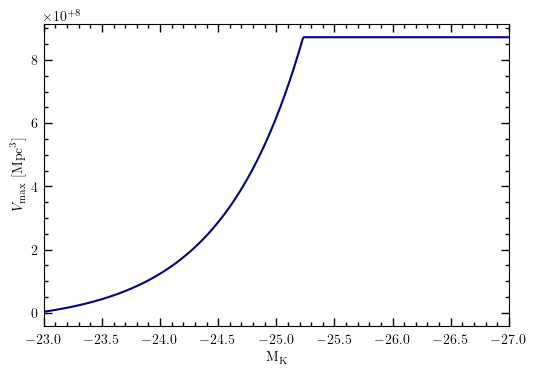

In [20]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(111)
ax.set_xlim([Mmax,Mmin])
ax.set_xlabel("${\\rm M_K}$")
ax.set_ylabel("$V_{\\rm max}$ [${\\rm Mpc}^{3}$]")
ax.plot(Marr,aVmaxMk,c="DarkBlue")
plt.savefig("VmaxMk.png")

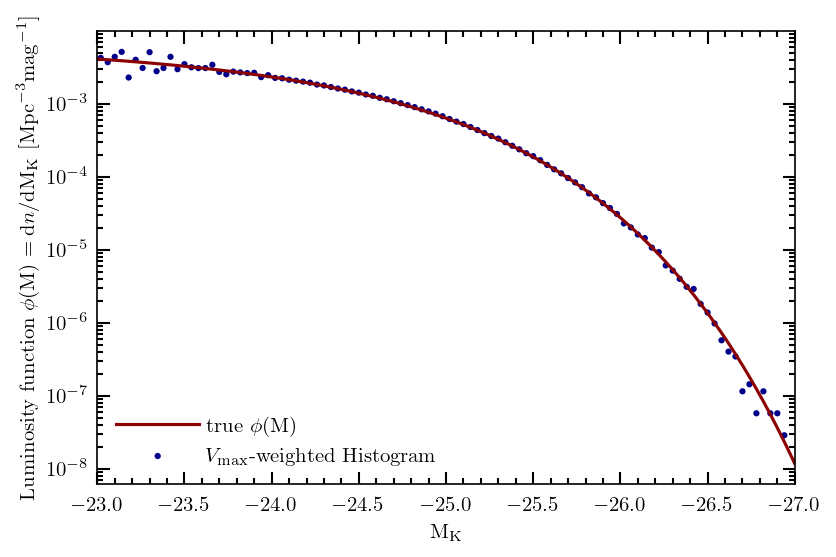

In [42]:
Mmax = -23
Mmin = -27

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([Mmax,Mmin])
ax.set_yscale("log")
ax.set_xlabel("${\\rm M_K}$")
ax.set_ylabel("Luminosity function $\phi({\\rm M})={\\rm d}n/{\\rm d M_K}$ [${\\rm Mpc}^{-3}{\\rm mag}^{-1}$]")
ax.plot(Marr,LFMarr,c="DarkRed",label="true $\phi({\\rm M})$")

mm = aMKs<Mmax

Nbins = 100
DeltaM = (Mmax - Mmin)/Nbins
invVmaxweights = 1/fVmaxMk(aMKs[mm])/DeltaM

hist, bins = np.histogram(aMKs[mm],bins=Nbins,range=(Mmin,Mmax),weights=invVmaxweights)
binC = (bins[:-1]+bins[1:])/2
ax.scatter(binC,hist,marker=".",c="DarkBlue",ec="none",label="$V_{\\rm max}$-weighted Histogram")

ax.legend(loc="lower left",handlelength=4)
plt.savefig("LF_Vmax_hist.png")

## Bootrarapping

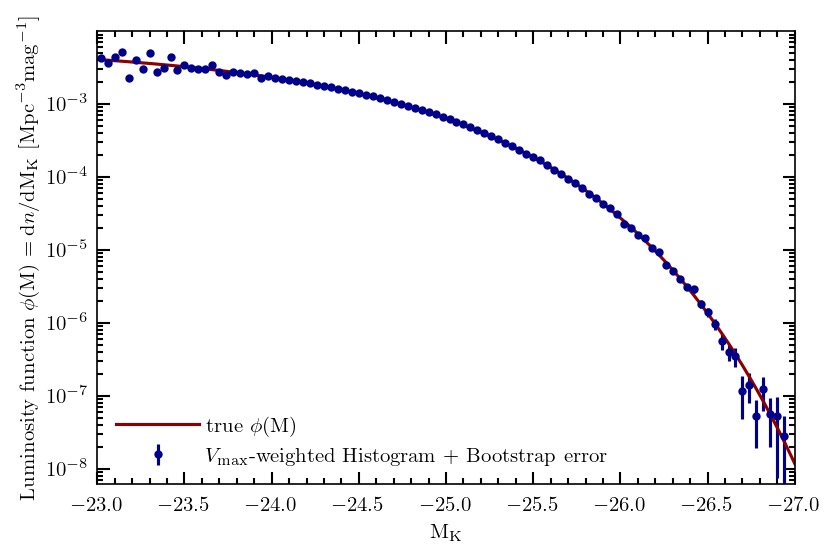

In [44]:
mm = aMKs<Mmax

Nbins = 100
DeltaM = (Mmax - Mmin)/Nbins

sample = aMKs[mm]
weight = 1/fVmaxMk(sample)/DeltaM

Nsample = len(sample)
Nbootstrap = 100

mean = np.zeros(Nbins)
var  = np.zeros(Nbins)

for bindx in range(Nbootstrap):
    resample = np.random.randint(Nsample, size=Nsample)
    sample_this = sample[resample]
    weight_this = weight[resample]
    hist, bins = np.histogram(sample_this,bins=Nbins,range=(Mmin,Mmax),weights=weight_this)
    
    mean = mean + hist
    var  = var + hist**2

mean = mean/Nbootstrap
var  = var/Nbootstrap - mean**2
err  = var**0.5

binC = (bins[:-1]+bins[1:])/2

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([Mmax,Mmin])
ax.set_yscale("log")
ax.set_xlabel("${\\rm M_K}$")
ax.set_ylabel("Luminosity function $\phi({\\rm M})={\\rm d}n/{\\rm d M_K}$ [${\\rm Mpc}^{-3}{\\rm mag}^{-1}$]")
ax.plot(Marr,LFMarr,c="DarkRed",label="true $\phi({\\rm M})$")
ax.errorbar(binC,mean,yerr=err,marker=".",color="DarkBlue",ls="none",label="$V_{\\rm max}$-weighted Histogram + Bootstrap error")

ax.legend(loc="lower left",handlelength=4)
plt.savefig("LF_Vmax_hist_bootstrap.png")

## Eddington bias

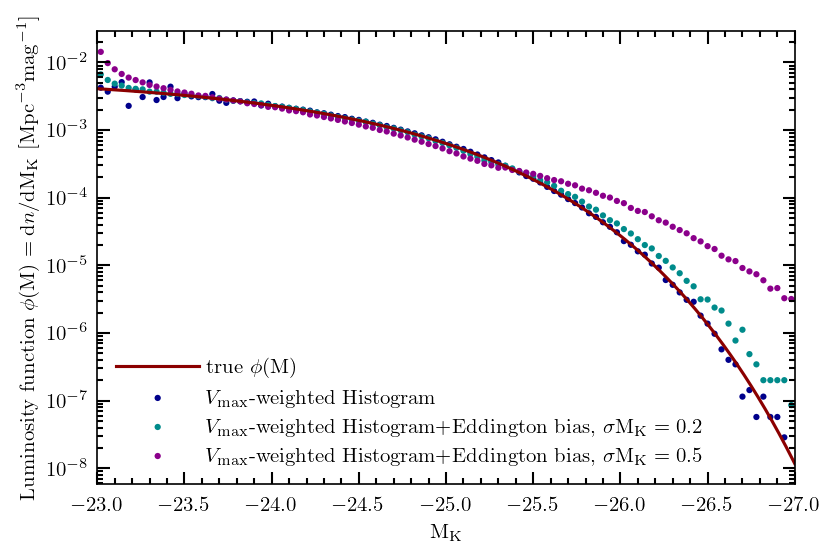

In [64]:
Mmax = -23
Mmin = -27

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([Mmax,Mmin])
ax.set_yscale("log")
ax.set_xlabel("${\\rm M_K}$")
ax.set_ylabel("Luminosity function $\phi({\\rm M})={\\rm d}n/{\\rm d M_K}$ [${\\rm Mpc}^{-3}{\\rm mag}^{-1}$]")
ax.plot(Marr,LFMarr,c="DarkRed",label="true $\phi({\\rm M})$")

mm = aMKs<Mmax
Nbins = 100
DeltaM = (Mmax - Mmin)/Nbins
invVmaxweights = 1/fVmaxMk(aMKs[mm])/DeltaM

hist, bins = np.histogram(aMKs[mm],bins=Nbins,range=(Mmin,Mmax),weights=invVmaxweights)
binC = (bins[:-1]+bins[1:])/2
ax.scatter(binC,hist,marker=".",c="DarkBlue",ec="none",label="$V_{\\rm max}$-weighted Histogram")

sigmaM = 0.2

aMKsE = aMKs + np.random.normal(loc=0.0,scale=sigmaM,size=len(aMKs))
mm = (aMKsE<=Mmax)*(aMKsE>Mmin)

Nbins = 100
DeltaM = (Mmax - Mmin)/Nbins
invVmaxweights = 1/fVmaxMk(aMKsE[mm])/DeltaM

hist, bins = np.histogram(aMKsE[mm],bins=Nbins,range=(Mmin,Mmax),weights=invVmaxweights)
binC = (bins[:-1]+bins[1:])/2
ax.scatter(binC,hist,marker=".",c="DarkCyan",ec="none",label="$V_{\\rm max}$-weighted Histogram+Eddington bias, $\sigma {\\rm M_K}=0.2$")

ax.legend(loc="lower left",handlelength=4)
plt.savefig("LF_Vmax_hist_Eddington.png")

sigmaM = 0.5

aMKsE = aMKs + np.random.normal(loc=0.0,scale=sigmaM,size=len(aMKs))
mm = (aMKsE<=Mmax)*(aMKsE>Mmin)

Nbins = 100
DeltaM = (Mmax - Mmin)/Nbins
invVmaxweights = 1/fVmaxMk(aMKsE[mm])/DeltaM

hist, bins = np.histogram(aMKsE[mm],bins=Nbins,range=(Mmin,Mmax),weights=invVmaxweights)
binC = (bins[:-1]+bins[1:])/2
ax.scatter(binC,hist,marker=".",c="DarkMagenta",ec="none",label="$V_{\\rm max}$-weighted Histogram+Eddington bias, $\sigma {\\rm M_K}=0.5$")

ax.legend(loc="lower left",handlelength=4)
plt.savefig("LF_Vmax_hist_Eddington.png")